# Mock mass-calibration comparing Ragagnin2020 and Diemer2019 Mcs

## 1) imports and constants

In [1]:
import hydro_mc, matplotlib.pyplot as plt, numpy as np, pint
from colossus.cosmology import cosmology
from colossus.halo import concentration
from scipy import optimize
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats

A_NFW = lambda c: (np.log(1.+c)-c/(1.+c))

ureg = pint.UnitRegistry()
ureg.define('Msun = 1.989e+30*kg')
ureg.define('kpc = 1e3*pc')
h0_units =  ureg.km/ureg.s/ureg.Mpc
G = 6.67408e-11*ureg.m**3/ureg.kg/ureg.s**2

## 2) Routines to get 2D NFW profiles given (rs, rho0) or (M,c, cosmology) 

In [2]:

def get_rho_crit_in_Msun_kpc3(h0):
    return (3*(100.*h0*h0_units)**2/(8*np.pi*G)).to('Msun/kpc^3').magnitude

def get_R_kpc(delta, a, omega_m, h0, M):
    critical_overdensity = hydro_mc.critical_overdensity(delta, a=a, omega_m = omega_m)
    rho_crit_Msun_kpc3 = get_rho_crit_in_Msun_kpc3(h0)
    r_3 = M/(critical_overdensity*4./3.*np.pi*rho_crit_Msun_kpc3)
    r = r_3**(1/3)
    #print('r',r)
    return r 

A_NFW = hydro_mc.f_NFW
sqrt = np.sqrt
log = np.log

def nfw2_return_from_rho0_rs(rho0, rs, radii):
    # si veda Lokas & Mamon 2001 ( https://ui.adsabs.harvard.edu/abs/2001MNRAS.321..155L/abstract )
    a=rs
    b=radii
    v1= -2*rho0*rs*((a**2 *  (a**2-b**2+a * sqrt(-a**2 + b**2)* np.arccos(a/b))/(a**2-b**2)**2))
    v2 = 2*rho0*a**3 * (1./(-a**2+b**2)+(a * np.arccosh(a/b))/(a**2-b**2)**(1.5))
    # we check if radii is scalar or array
    if hasattr(radii, "__getitem__") and not np.array(radii).shape==(): 
        mask = np.isnan(v1)
        v1[mask] = v2[mask]
        return v1
    else:
        return v1 if np.isnan(v2) else v2

def nfw2_profile_from_M_c(M,c, delta, a, omega_m, h0,radii):
    #print('M',M_1e10Msun, M)
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    a=rs
    #print('rho0', rho0, 'rs', rs, 'r',r)
    return nfw2_return_from_rho0_rs(rho0, rs, radii)

## 3) Routine to generate noisy NFW profile with a given S/N


In [3]:

def genera_profilo_con_SN(M, c,  a, delta, omega_m, omega_b, sigma8, h0, sn, radii_n=50, plotta=False):

    radii = np.logspace(-1, 3, radii_n)
    rho_ideale = nfw2_profile_from_M_c(M, c, delta, a, omega_m,   h0, radii)
    rho_perturbato = rho_ideale * np.exp(np.random.normal(loc=0, scale=1./sn, size =  radii_n))
    rho_perturato_errore = rho_perturbato*1./sn
    if plotta:
        f, axes = plt.subplots(1,2, figsize=(15,5))
        ax = axes[0]
        ax.hist(np.log(rho_perturbato/rho_ideale), density=True)
        xs = np.linspace(-1,1,20)
        ax.plot(xs, stats.norm.pdf(xs, 0., 1./sn))
        ax.set_xlabel(' log10(rho perturbato/rho ideale) ')
        ax.set_ylabel('histo density ')
        
        ax = axes[1]        
        ax.plot(radii,rho_perturbato, label = 'rho SN=%.1f'%sn )
        ax.plot(radii,rho_ideale, label = 'rho ideale' )
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(' r [kpc] ')
        ax.set_ylabel(r' $\rho [M_\odot/kpc^2]$ ')
        ax.legend()
        f.suptitle('halo with M=%.1e Msun; S/N = %.1f; radial bins = %d'%(M, sn, radii_n))
    return radii, rho_ideale, rho_perturbato, rho_perturato_errore


# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(M=1.e14, c=4., a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 5., radii_n=50, plotta=True);

# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(1.e14, c=4.,  a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 5., radii_n=1000, plotta=True);

# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(1.e14, c=4.,  a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 1000., radii_n=1000, plotta=True);


## 4) Mass calibration routines with Ragagnin2020 and Diemer2019 Mcs rels

In [50]:
def nfw2_profile_from_M200c_Ragagnin2020(M, a, delta, omega_m, omega_b, sigma8, h0,radii):
    Rhalo = get_R_kpc('200c', a, omega_m, h0, M)
    c = hydro_mc.concentration_from_mc_relation(delta, M=M, a=a, omega_m = omega_m, omega_b = omega_b, sigma8=sigma8, h0=h0)
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)

def nfw2_profile_from_M200c_Diemer2019(M, a, delta, omega_m, omega_b, sigma8, h0,radii):

    _params = {'flat': True, 
               'H0': h0*100., 
               'Om0': omega_m, 
               'Ob0': omega_b,
               'sigma8': sigma8,
              'ns':.963}
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    _cosmo = cosmology.setCosmology('myCosmo', _params)
    cosmology.setCurrent( _cosmo)
    if M>1e16:
        return np.nan
    #diemer vuole masse/h
    #c = concentration.modelDiemer19(M*h0, 1./a-1.)[0]
    c = concentration.concentration(M*h0, '200c', 1./a-1., model='diemer19')[0]
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)


def calibra_massa_su_profilo(rho, log_rho_err, funzione_profilo_M_radii):
       
    errorfunc = lambda logM: (np.log(funzione_profilo_M_radii(np.exp(logM))) - np.log(rho))/log_rho_err  
    
    p1, success = optimize.leastsq( errorfunc, x0 = 14.)
    if not success:
        print(p1, success)
        raise Exception('ahi ahi toppai!')
    return np.exp(p1)

def calibra_massa_Ragagnin2020(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    M = calibra_massa_su_profilo(
       rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Ragagnin2020(M, a, delta, omega_m, omega_b, sigma8, h0,radii)
    )
    c = hydro_mc.concentration_from_mc_relation(delta, M=M, a=a, omega_m = omega_m, omega_b = omega_b, sigma8=sigma8, h0=h0)
    return M,c

def calibra_massa_Diemer2019(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    M = calibra_massa_su_profilo(
      rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Diemer2019(M, a,  delta, omega_m, omega_b, sigma8, h0,radii)
    )
    c = concentration.concentration(M*h0, '200c', 1./a-1., model='diemer19')[0]
    return M,c

## 5) Routine to generate a mock (M,c) given a model (e.g.  Okabe2011)

In [51]:
def get_M_c_from_model(model='Okabe2011', M=None, delta='200c', omega_m = None, omega_b = None, sigma8 = None, h0 = None, a=None):
    if model=='Ragagnin2020':
        c = hydro_mc.concentration_from_mc_relation(delta, M=    M, a=a, omega_m = omega_m,  omega_b =omega_b,  sigma8=sigma8,  h0=h0)
        c = np.exp(np.random.normal(np.log(c), scale=0.38))
        return M,c
    elif model=='Okabe2011':
        A = np.random.normal(loc=-0.37, scale=0.2)
        C = np.random.normal(loc=5.75, scale=2.)
        c = C * (M/(1e14/h0))**(A)
        c = 10.**np.random.normal(np.log10(c), scale=0.18)
        return M,c
    elif model=='Diemer2019':
        # scommentare se si vuole provare lo stesso esperimento calibrando un profilo generato con Mc di Diemer
        c =  concentration.modelDiemer15fromM(M*h0, 1./a-1.) #diemer Vuole M/h
        return M,c
    elif model=='Capasso2019':
        if M is not None:
            raise Exception('if c_orig==Capasso2020, you need to pass a=None and M=None,'+
                            ' to ensure that I will set it from'+
                            ' https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1043C/abstract ')
        z=  np.random.normal(loc=(0.2+0.36)/2., scale=0.36-0.2)
        a=1./(1.+z)
        # scommentare se si vuole provare lo stesso esperimento calibrando un profilo generato con Mc di Diemer
        M = np.random.normal(loc=9.44, scale=1.7)*1e14
        c = np.random.normal(loc=5.4, scale=2.)
        return M,c
    else:
        raise Exception('model must be Ragagnin2020 o Okabe2011 o Diemer2019')

print('Model = Okabe2011, M=%.1eMsun c=%.1f and h0 = 0.7'%(get_M_c_from_model(model='Okabe2011', M=1e14, h0=.7)))
print('Model = Capasso2019, M=%.1eMsun c=%.1f'%(get_M_c_from_model(model='Capasso2019')))

Model = Okabe2011, M=1.0e+14Msun c=2.5 and h0 = 0.7
Model = Capasso2019, M=9.2e+14Msun c=3.3


## 6) Perform 1 mass calibration Ragagnin2020 vs. Diemer2019

In [61]:
print(1/(1.+0.3))
def confronta(M = 1.e14, sn=None, outputta=False, plotta=False, fig=None, ax=None, delta='200c', params =  None, model='Ragagnin2020'):
    # in teoria anche la cosmologia potrebbe essere sconosciuta
    omega_m = 0.27
    omega_b = 0.004
    sigma8 = 0.8
    h0= .7
    a = .8 #/(1.+0.1)
    M,c = get_M_c_from_model(model, M, delta, omega_m, omega_b, sigma8,  h0, a)
    radii, prof2d_ideal, prof2d_niosy, prof2d_niosy_error = genera_profilo_con_SN(M, c,  a=a, delta=delta, omega_m=omega_m, omega_b=omega_b,
                                                                    sigma8=sigma8, h0=h0, sn = sn,radii_n=50, 
                                                                    plotta=False)
    
    # ora provo a recuperarlo usando Ragag2020 o Diemer2016
    
    RagagninM, RagagninC = calibra_massa_Ragagnin2020(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    
    DiemerM, DiemerC = calibra_massa_Diemer2019(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    if plotta:
        ax.set_title('Mock  mass-calibration from %s M-c'%model)
        ax.plot(radii*1.1, prof2d_ideal, label='ideal profile' )
        #ax.plot(radii, nfw2_profile_from_M_c_prova(Mvir/ureg.Msun/1e10, c_vir, delta, params['a'], params['omega_m'], params['h0'], radii), label='idel profile 2' )
        ax.plot(radii*.9, prof2d_niosy, label='profile with S/N=5')
        ax.plot(radii, nfw2_profile_from_M_c(RagagninM, RagagninC, delta, a, omega_m, h0, radii), label='mass recovered with Ragagnin+2020' )
        ax.plot(radii, nfw2_profile_from_M_c(DiemerM, DiemerC, delta, a, omega_m, h0, radii), label='mass recovered with Diemer+2016' )
    if outputta:
        print('Ragagnin Recovered mass %e: Msun and concentration: %.2f'%(
            RagagninM,RagagninC))
        print('Dimer Recovered mass %e: Msun and concentration: %.2f'%(
            DiemerM, DiemerC))
        print('Original mass %e: Msun and concentration: %.2f from model=%s'%(
            M,c, model))
    return M, RagagninM, DiemerM

0.7692307692307692


/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


Ragagnin Recovered mass 4.517847e+14: Msun and concentration: 4.48
Dimer Recovered mass 3.763615e+14: Msun and concentration: 3.82
Original mass 5.000000e+14: Msun and concentration: 2.58 from model=Ragagnin2020

Ragagnin Recovered mass 4.706770e+14: Msun and concentration: 4.42
Dimer Recovered mass 4.930696e+14: Msun and concentration: 3.78
Original mass 5.000000e+14: Msun and concentration: 3.76 from model=Diemer2019

Ragagnin Recovered mass 1.005365e+15: Msun and concentration: 3.47
Dimer Recovered mass 4.135441e+15: Msun and concentration: 4.50
Original mass 5.000000e+14: Msun and concentration: 23.08 from model=Okabe2011

Ragagnin Recovered mass 5.286183e+14: Msun and concentration: 4.26
Dimer Recovered mass 8.444596e+14: Msun and concentration: 3.77
Original mass 4.627785e+14: Msun and concentration: 7.18 from model=Capasso2019



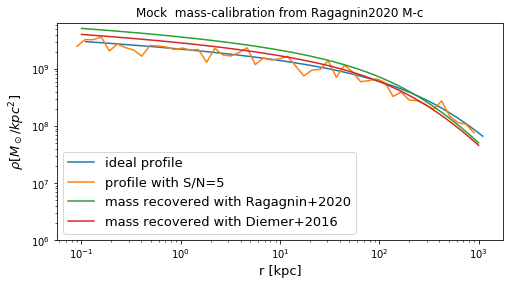

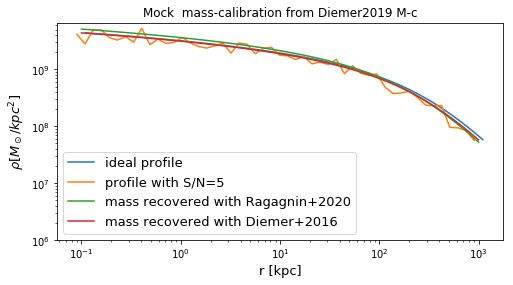

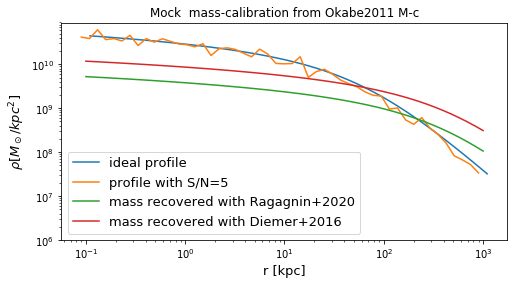

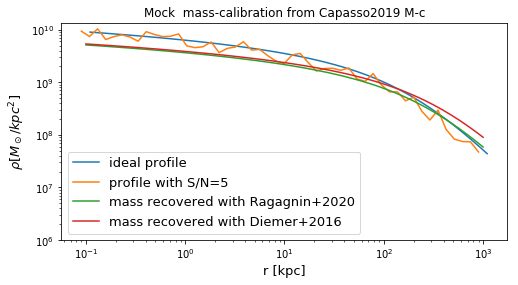

In [62]:
 


fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = 5e14, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e6,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()

 


fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = 5e14, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True, model='Diemer2019')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e6,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()


fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = 5e14, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True, model='Okabe2011')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e6,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()

fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = None, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True, model='Capasso2019')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e6,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()

## 6) Perform N=1000 mass calibration Ragagnin2020 vs. Diemer2019

In [67]:


def confronta_n(n, M = 1e14, model = 'Ragagnin2020',  sn=None, plotta=False, bins=None, fig=None, ax=None):
    i=-1
    M1s =[]
    M2s =[]
    _n=0.
    while True:
        i+=1
        try:
            _M, _M1, _M2 =  confronta(M = M, sn=sn, model=model)
            M1s.append(_M1)
            M2s.append(_M2)
            _n+=1
        except Exception as e:
            print(e)
            pass
        if _n>n or i>10000:
            break
    #print(M1s)
    ra1 = np.array([x  for x in M1s])
    ra2 = np.array([x  for x in M2s])
    ra = ra1/ra2
    print('ragagnin/dimer: %.3f'%(np.mean(ra)))
    print('ragagnin/orig: %.3f'%(np.mean(np.array(ra1/_M))))
    print('diemer/orig: %.3f'%(np.mean(np.array(ra2/_M))))
    print('orig/orig: %.3f'%(np.mean(np.array(_M/ra2))))
    if plotta:
        if fig is None:
            fig,ax = plt.subplots(1,figsize=(8,4))

        # best fit of data
        (mu1, sigma1) = norm.fit(ra1/_M)
        (mu2, sigma2) = norm.fit(ra2/_M)
        if bins is None:
            bins = np.linspace(0.,2.,40)
        n, bins, patches =  ax.hist(ra1/_M ,label = 'Ragagnin+2020', bins=bins, density=True, alpha=0.8,color='blue')
        # add a 'best fit' line
        y = mlab.normpdf( bins, mu1, sigma1)
        l = ax.plot(bins, y, '--', linewidth=2,c='blue')
        n, bins, patches =  ax.hist(ra2/_M ,label = 'Diemer+2016', bins=bins,density=True,  alpha=0.8,color='red')
        # add a 'best fit' line
        y = mlab.normpdf( bins, mu2, sigma2)
        l = ax.plot(bins, y, '--', linewidth=2,c='red')
        #ax.axvline(9e13, label='Original Mass',color='black' )
        ax.text(.95,.95,'Mock  mass-calibration\nfrom %s M-c'%model,ha='right', va='top',
    transform=ax.transAxes,fontsize=13)
        ax.set_ylabel(r'$n$',fontsize=13)
         #ax.set_xscale('log')
        ax.axvline(1.)




/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


ragagnin/dimer: 0.873
ragagnin/orig: 1.008
diemer/orig: 1.261
orig/orig: 0.918


/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


ragagnin/dimer: 1.016
ragagnin/orig: 0.928
diemer/orig: 1.110
orig/orig: 1661397.266
ragagnin/dimer: 0.930
ragagnin/orig: 1.365
diemer/orig: 1.559
orig/orig: 791577.390


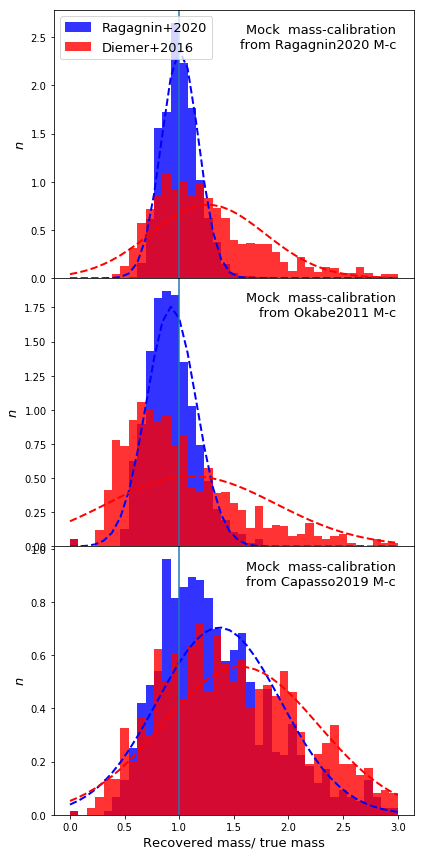

In [71]:
fig,ax = plt.subplots(3,figsize=(6,12),sharex=True)
ax[-1].set_xlabel('Recovered mass/ true mass',fontsize=13)


confronta_n(1000, sn=5., plotta=True, M=5e14, model='Ragagnin2020', bins =  np.linspace(0.,3.,40), fig=fig,ax=ax[0])
#confronta_n(1000, sn=5., plotta=True, c_orig='Diemer2019')
confronta_n(1000, sn=5., plotta=True,  M=5e14,model='Okabe2011', bins =  np.linspace(0.,3.,40), fig=fig,ax=ax[1])
confronta_n(1000, sn=5., plotta=True,   model='Capasso2019', M=None, bins =  np.linspace(0.,3.,40), fig=fig,ax=ax[2])

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].legend(fontsize=13,loc=2)

## random tests

In [65]:
h0 = .6
_params = {'flat': True, 
               'H0': h0*100, 
               'Om0': .3, 
               'Ob0': 0.0491,
               'sigma8': 0.834,
              'ns':.9624}
a  = 1.
M = 1.7e14
M_su_h = M*h0
print('M = %.1eMsun = %.1eMsun/h; c=%.1f'%(M, M_su_h,concentration.modelDiemer19(M_su_h, 1./a-1.)[0]))
print('M = %.1eMsun = %.1eMsun/h; c=%.1f'%(M, M_su_h,concentration.concentration(M_su_h, '200c',1./a-1., model='diemer19')))
print('M = %.1eMsun = %.1eMsun/h; c=%.1f'%(M, M_su_h,concentration.concentration(M_su_h, 'vir',1./a-1., model='diemer19')))

M = 1.7e+14Msun = 1.0e+14Msun/h; c=4.3
M = 1.7e+14Msun = 1.0e+14Msun/h; c=4.3
M = 1.7e+14Msun = 1.0e+14Msun/h; c=6.1
